In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rng = np.random.RandomState(20180201)
DEFAULT_SEED = 20180201
DATA_DIR = "../data/"
DATA_FILE = "creditcard.csv"

In [3]:
data = pd.read_csv(DATA_DIR+DATA_FILE)
stats = pd.DataFrame({'mean':data.mean(), 'std':data.std(), 'skew':data.skew()})

# normalize the data
data['Amount'] = data['Amount'].apply(lambda x: np.log(x+1e-6))
data.loc[:,'V1':'Amount'] = data.loc[:,'V1':'Amount'].apply(lambda x: (x-x.mean())/x.std())
#data.loc[:,'V1':'V28'] = data.loc[:,'V1':'V28'].apply(lambda x: (x-x.min())/(x.std(x.max()-x.min())))

/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


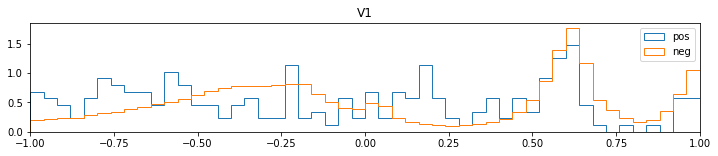

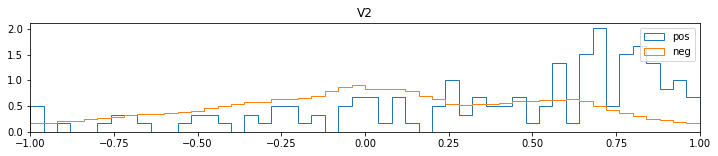

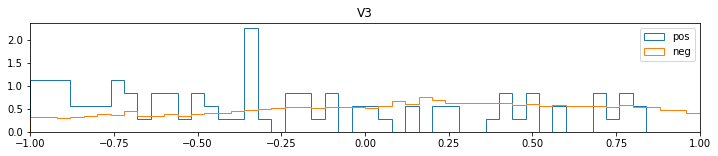

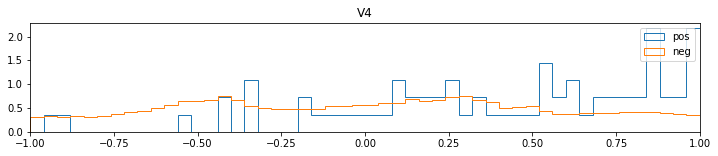

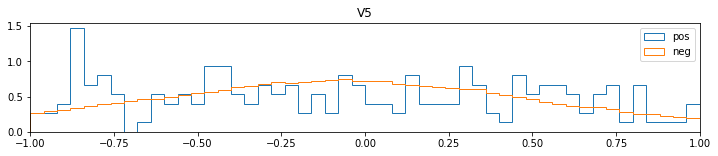

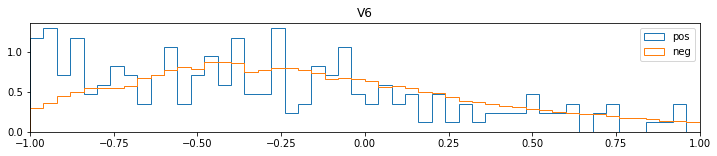

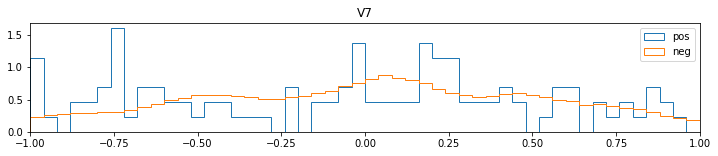

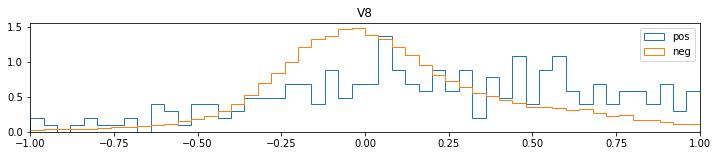

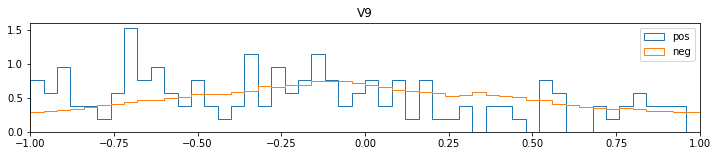

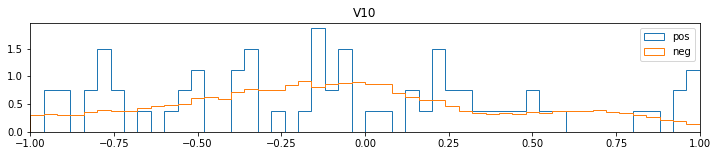

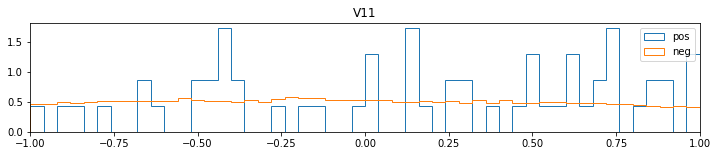

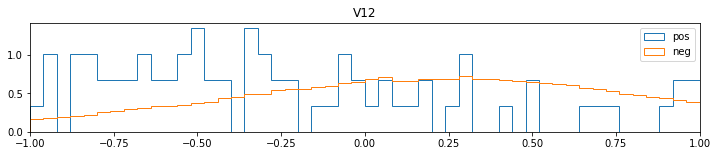

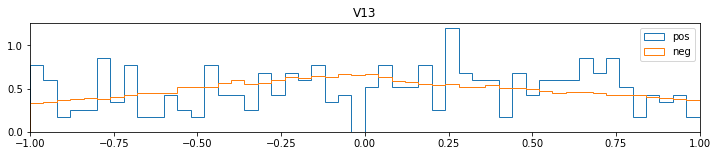

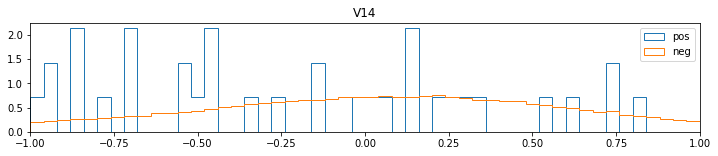

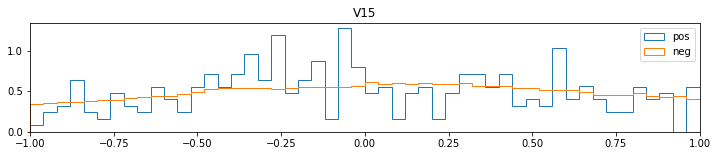

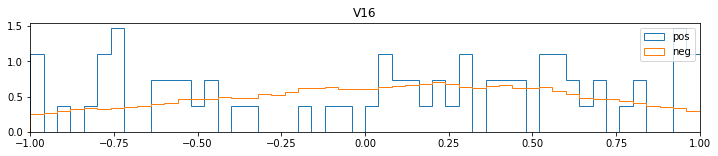

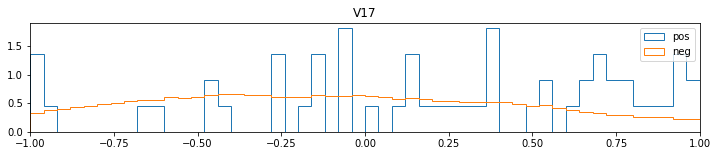

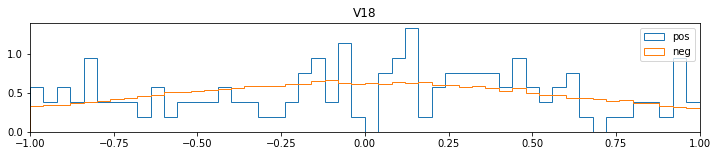

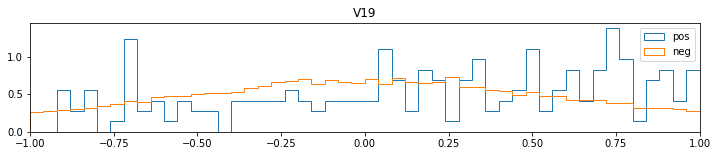

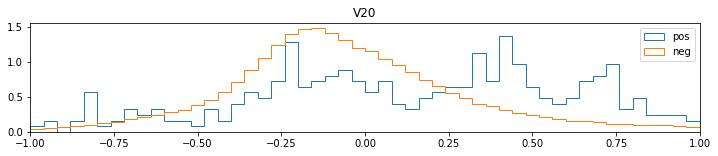

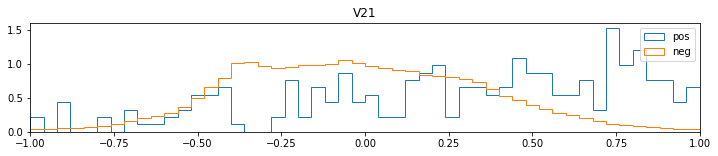

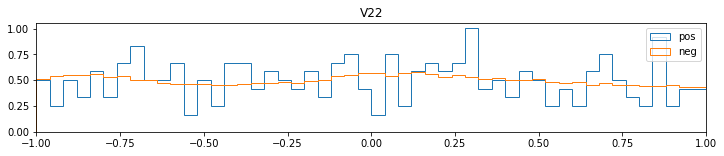

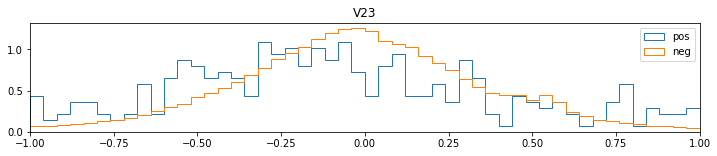

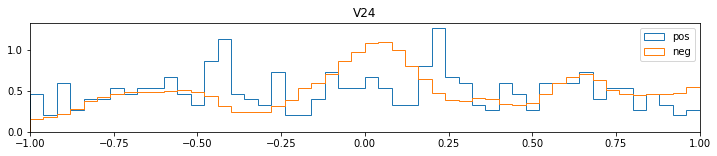

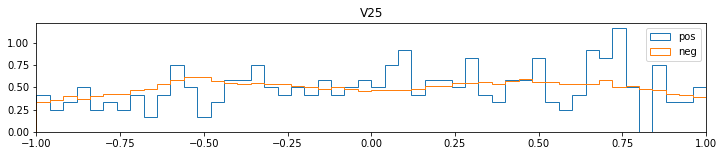

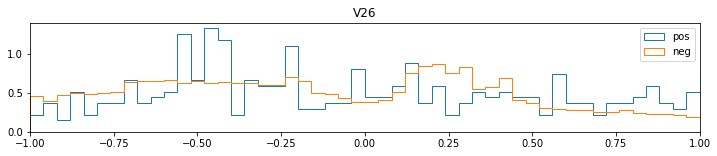

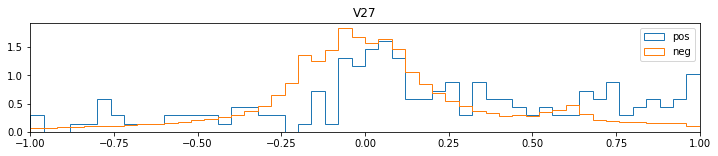

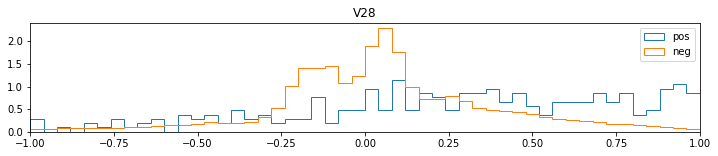

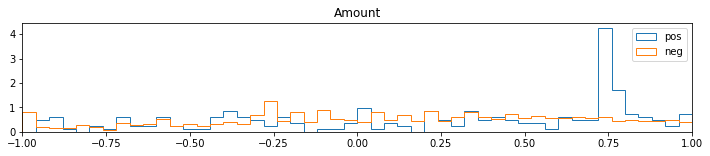

In [4]:
# plot the histograms of data in each axises
plot=True
if plot:
    pos_data = data[data["Class"]==1]
    neg_data = data[data["Class"]==0]
    for key in data.keys()[1:-1]: # for all principle components
        fig = plt.figure(figsize=(12,2))
        plt.hist(pos_data[key], histtype="step", normed=True, bins=50, range=(-1,1), label="pos")
        plt.hist(neg_data[key], histtype="step", normed=True, bins=50, range=(-1,1), label="neg")
        plt.xlim(-1,1)
        plt.title(key)
        plt.legend()
        fig.savefig(key+"_Scaled.png")

In [5]:
def split_DataFrame(data, label, frac, rng=None):
    '''
    Split the data into two part, and remain the same event propotion in the results.
    
    Input:
        data (pd.DataFrame): the Input data
        label (string): the event class label
        frac (float): the propotion of the first part
        rng (np.RandomState): NumPy random state

    Return:
        tuple of two subparst of the data
    '''
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    subdf1 = pd.DataFrame()
    subdf2 = pd.DataFrame()
    count = data[label].value_counts()
    for val in count.keys():
        df = data[data[label]==val]
        mask = rng.rand(len(df)) < frac
        subdf1 = pd.concat([df[mask]] + [subdf1])
        subdf2 = pd.concat([df[~mask]] + [subdf2])
    return (subdf1, subdf2)

def oversample(df_input, label, rng=None):
    '''
    Simply duplicate the data with minority label to let all category have the close amount
    
    Input:
        df_input (pd.DataFrame): the Input data
        label (string): the event class label
        rng (np.RandomState): NumPy random state
        
    Return:
        oversampled DataFrame
    '''
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    count = df_input[label].value_counts()
    repeat = np.array(np.ceil(count.max()/count), dtype=np.int)
    res = pd.DataFrame()
    for val, nrep in zip(count.keys(), repeat):
        df = df_input[df_input[label]==val]
        res = pd.concat([res] + [df]*nrep)
    return res.sample(frac=1, random_state=rng).reset_index(drop=True)

def smote_oversample(df, lebal, val, n_sample, k_neighbor, n_gen, rng=None):
    
    if rng is None:
        rng = np.random.RandomState(DEFAULT_SEED)
    df_minority = df[df[lebal]==val]
    assert n_sample <= df_minority.shape[0]
    assert k_neighbor < df_minority.shape[0]
    df_minority = np.array(df_minority)
    for i in range(n_sample):
        xi = df_minority[i]
        resdf = np.delete(df_minority, i, 0)
        dist = []
        for xii in resdf:
            idist = np.linalg.norm(xi-xii)
            dist.append(idist)
        dist = np.array(dist)
        ridx = rng.randint(k_neighbor,size=n_gen)
        rshift = rng.rand(n_gen,1)
        gen = xi + (resdf[dist.argsort()[:k_neighbor]][ridx]-xi) * rshift
        gen_df = pd.DataFrame(gen, columns=df.columns)
        df = df.append(gen_df)
    return df.sample(frac=1, random_state=rng).reset_index(drop=True)

In [6]:
# train : test : valid = 0.6 : 0.2 : 0.2 
train_df, evalu = split_DataFrame(data, label='Class', frac=0.6, rng=rng)
#train_df = oversample(train_df, label='Class', rng=rng)
train_df = smote_oversample(train_df, 'Class', 1, 280, 140, 700, rng=rng)
test_df, valid_df = split_DataFrame(evalu, label='Class', frac=0.5, rng=rng)

train = train_df.as_matrix()
test = test_df.as_matrix()
valid = valid_df.as_matrix()

np.savez_compressed(DATA_DIR+'ccdataset.npz', train=train, test=test, valid=valid)